**MOMENTUM 2026 - DATATHON**

*Solve real-world problems using real data — not toy datasets, not textbook questions.*

# Step 1- Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score



## Step 2- Load Datasets

In [3]:
loan_df= pd.read_csv("C:/Users/KIIT/Downloads/train.csv")
loan_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
txn_df=pd.read_csv("c:/Users/KIIT/Downloads/transactions_datathon_ready.csv")
txn_df.head()


,amount,zip,mcc,date,use_chip,merchant_city,merchant_state,user_id,transaction_id
0,201.787069,48036.0,4899.0,2010-01-01 13:47:00,Online Transaction,ONLINE,CA,0,1
1,42.283621,23707.0,5719.0,2010-01-01 11:29:00,Swipe Transaction,Portsmouth,VA,0,2
2,7.060345,62865.0,5411.0,2010-01-01 06:16:00,Swipe Transaction,Mulkeytown,IL,0,3
3,4.767241,46124.0,5411.0,2010-01-01 11:44:00,Swipe Transaction,Edinburgh,IN,0,4
4,58.208621,70605.0,5411.0,2010-01-01 09:55:00,Swipe Transaction,Lake Charles,LA,0,5


*#Step 2.1- Aggregate transaction data*

In [5]:
txn_agg = txn_df.groupby("user_id").agg({
    "amount": ["sum", "mean", "count"]
}).reset_index()

txn_agg.columns = [
    "user_id",
    "total_spend",
    "avg_spend",
    "txn_count"]

# Step 3- Dataset Merging & Preprocessing

In [6]:
#Rename 'id' in loan_df to 'user_id' for consistent merging across transaction data
loan_df_renamed = loan_df.rename(columns={'id': 'user_id'})

df = loan_df_renamed.merge(txn_agg, on="user_id", how="left")

df[["total_spend", "avg_spend", "txn_count"]] = df[
    ["total_spend", "avg_spend", "txn_count"]
].fillna(0)

#Check class imbalance
default_rate = df["loan_status"].mean()
print("Overall default rate:", round(default_rate, 3))


#Feature selection
features = [
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_cred_hist_length",
    "total_spend",
    "avg_spend",
    "txn_count"
]

X = df[features]
y = df["loan_status"]

#Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

#Feature scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing complete.")

Overall default rate: 0.142
Train size: (46916, 9)
Test size: (11729, 9)
Data preprocessing complete.


*# Step 3.1- Merged Data Description*

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,58645.0,29322.000000,16929.497605,0.000000,14661.000000,29322.000000,43983.000000,5.864400e+04
person_age,58645.0,27.550857,6.033216,20.000000,23.000000,26.000000,30.000000,1.230000e+02
person_income,58645.0,64046.172871,37931.106979,4200.000000,42000.000000,58000.000000,75600.000000,1.900000e+06
person_emp_length,58645.0,4.701015,3.959784,0.000000,2.000000,4.000000,7.000000,1.230000e+02
loan_amnt,58645.0,9217.556518,5563.807384,500.000000,5000.000000,8000.000000,12000.000000,3.500000e+04
loan_int_rate,58645.0,10.677874,3.034697,5.420000,7.880000,10.750000,12.990000,2.322000e+01
loan_percent_income,58645.0,0.159238,0.091692,0.000000,0.090000,0.140000,0.210000,8.300000e-01
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.000000,3.000000,4.000000,8.000000,3.000000e+01
loan_status,58645.0,0.142382,0.349445,0.000000,0.000000,0.000000,0.000000,1.000000e+00
total_spend,58645.0,749.234350,1217.337383,-6451.840862,12.651724,573.029922,1274.291379,5.938593e+04


# Step 4-Feature Engineering

In [8]:

#Create flag conditions


# High loan-to-income flag
df["high_debt_flag"] = df["loan_percent_income"] > 0.20

# Top quartile spending flag
spend_q3 = df["avg_spend"].quantile(0.75)
df["high_spend_flag"] = df["avg_spend"] >= spend_q3

# Combined risk flag
df["combined_flag"] = df["high_debt_flag"] & df["high_spend_flag"]


#Calculate default rates
overall_default = df["loan_status"].mean()

flag_default = df[df["combined_flag"]]["loan_status"].mean()

non_flag_default = df[~df["combined_flag"]]["loan_status"].mean()


# 6. Print results (evidence)

print("Overall default rate:", round(overall_default, 3))
print("Default rate (combined high-risk group):", round(flag_default, 3))
print("Default rate (others):", round(non_flag_default, 3))
print("Risk multiplier:", round(flag_default / overall_default, 2))

Overall default rate: 0.142
Default rate (combined high-risk group): 0.21
Default rate (others): 0.14
Risk multiplier: 1.47


# Step 5- Derived Behavioral Indicator

In [12]:
###FLAG 3 — Baseline Signal Establishment
#1 Prepare static-only feature dataset
# Target
y = loan_df["loan_status"]

# Drop ID + target
X_static = loan_df.drop(columns=["loan_status", "id"], errors="ignore")

# Keep only numeric columns for baseline simplicity
X_static = X_static.select_dtypes(include=np.number).fillna(0)

#2 Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_static, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

#3️ Scale + Logistic Regression baseline
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

baseline_model = LogisticRegression(max_iter=1000)

baseline_model.fit(X_train_scaled, y_train)
y_pred = baseline_model.predict(X_test)
y_pred_prob = baseline_model.predict_proba(X_test_scaled)[:, 1]

#4️ Baseline ROC-AUC score
baseline_auc = roc_auc_score(y_test, y_pred_prob)
print("Baseline ROC-AUC:", round(baseline_auc, 4))

#5️ Cross-validation robustness
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    baseline_model,
    scaler.fit_transform(X_static),
    y,
    cv=cv,
    scoring="roc_auc"
)

print("CV ROC-AUC Mean:", cv_scores.mean())
print("CV ROC-AUC Std:", cv_scores.std())

c:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Baseline ROC-AUC: 0.8717
CV ROC-AUC Mean: 0.8667033127303402
CV ROC-AUC Std: 0.003959272325846616


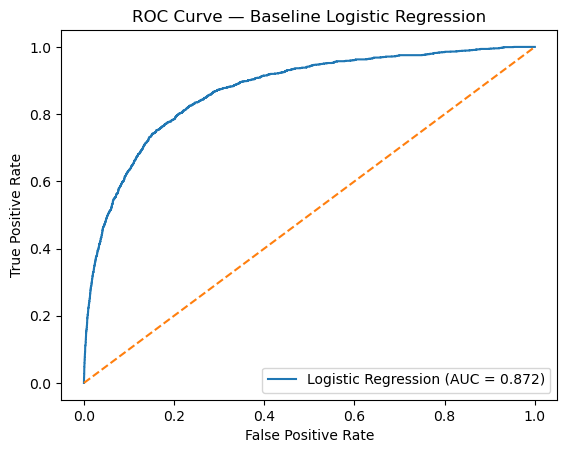

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute AUC value
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")  # random guess line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Baseline Logistic Regression")
plt.legend(loc="lower right")

plt.show()


In [13]:
from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Accuracy Score

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92     10059
           1       0.00      0.00      0.00      1670

    accuracy                           0.86     11729
   macro avg       0.43      0.50      0.46     11729
weighted avg       0.74      0.86      0.79     11729



c:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Step 6- Aggregation-based Feature Creation

In [17]:
print("Transactions count per user (first 5 rows):")
display(df[['user_id', 'txn_count']].head())

Transactions count per user (first 5 rows):


,user_id,txn_count
0,0,45
1,1,47
2,2,35
3,3,33
4,4,34


In [18]:
highest_txn_count = df['txn_count'].max()
highest_txn_users = df[df['txn_count'] == highest_txn_count][['user_id', 'txn_count']]

print(f"User(s) with the highest transaction count ({int(highest_txn_count)} transactions):")
display(highest_txn_users.reset_index(drop=True))

User(s) with the highest transaction count (49 transactions):


,user_id,txn_count
0,18,49
1,32,49
2,38,49
3,105,49
4,113,49
...,...,...
3030,58598,49
3031,58609,49
3032,58624,49
3033,58626,49


# Step 7- Feature Transformation

In [19]:
# Ensure 'date' column in txn_df is datetime type
txn_df['date'] = pd.to_datetime(txn_df['date'])

# Sort txn_df by user and date for correct time difference calculations
txn_df_sorted = txn_df.sort_values(by=['user_id', 'date'])

# Calculate time difference between consecutive transactions for each user
txn_df_sorted['time_diff_seconds'] = txn_df_sorted.groupby('user_id')['date'].diff().dt.total_seconds()

# Identify 'streaks' of transactions within a 24-hour window (86400 seconds)
# A new segment starts if the previous transaction was more than 24 hours ago, or if it's the first transaction for the user
txn_df_sorted['txn_24h_segment'] = (txn_df_sorted['time_diff_seconds'].isnull()) | (txn_df_sorted['time_diff_seconds'] >= 86400)
txn_df_sorted['txn_24h_segment'] = txn_df_sorted.groupby('user_id')['txn_24h_segment'].cumsum()

# Count transactions within each 24h segment for each user
txn_counts_in_segments = txn_df_sorted.groupby(['user_id', 'txn_24h_segment']).size().reset_index(name='count_in_segment')

# Get the maximum number of consecutive transactions within 24 hours for each user
max_txn_24h_count_per_user = txn_counts_in_segments.groupby('user_id')['count_in_segment'].max().reset_index(name='max_txn_24h_count')

# Ensure user_id columns are of the same type for merging
# Use pd.Int64Dtype() to handle potential NaNs gracefully if some user_ids don't have transaction data
df['user_id'] = df['user_id'].astype(pd.Int64Dtype())
max_txn_24h_count_per_user['user_id'] = max_txn_24h_count_per_user['user_id'].astype(pd.Int64Dtype())
df = df.merge(max_txn_24h_count_per_user, on='user_id', how='left')
df['max_txn_24h_count'] = df['max_txn_24h_count'].fillna(0) # Fill NaN for users with no transactions

# To add 'year' and 'month' features to df (user-level), we can take, for example, the year/month of the first transaction.
first_txn_date_per_user = txn_df.groupby('user_id')['date'].min().reset_index()
first_txn_date_per_user['first_txn_year'] = first_txn_date_per_user['date'].dt.year
first_txn_date_per_user['first_txn_month'] = first_txn_date_per_user['date'].dt.month

first_txn_date_per_user['user_id'] = first_txn_date_per_user['user_id'].astype(pd.Int64Dtype())
df = df.merge(first_txn_date_per_user[['user_id', 'first_txn_year', 'first_txn_month']], on='user_id', how='left')

print("New date-related and transaction frequency features added to df.")
print("First few rows of updated df with new features:")
display(df[['user_id', 'first_txn_year', 'first_txn_month', 'max_txn_24h_count']].head())

New date-related and transaction frequency features added to df.
First few rows of updated df with new features:


,user_id,first_txn_year,first_txn_month,max_txn_24h_count
0,0,2010,1,45
1,1,2010,1,47
2,2,2010,1,35
3,3,2010,1,33
4,4,2010,1,34


# Step 8- Feature Engineering: Static Feature Identification & Selection

In [20]:
static_features = X_static.columns.tolist()
enhanced_features = static_features + ['max_txn_24h_count', 'first_txn_year', 'first_txn_month']

X_enhanced = df[enhanced_features].copy()

print("Shape of X_enhanced:", X_enhanced.shape)
print("First 5 rows of X_enhanced:")
display(X_enhanced.head())

Shape of X_enhanced: (58645, 10)
First 5 rows of X_enhanced:


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,max_txn_24h_count,first_txn_year,first_txn_month
0,37,35000,0,6000,11.49,0.17,14,45,2010,1
1,22,56000,6,4000,13.35,0.07,2,47,2010,1
2,29,28800,8,6000,8.90,0.21,10,35,2010,1
3,30,70000,14,12000,11.11,0.17,5,33,2010,1
4,22,60000,2,6000,6.92,0.10,3,34,2010,1


In [21]:
X_train_enhanced, X_test_enhanced, y_train_enhanced, y_test_enhanced = train_test_split(
    X_enhanced, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Shape of X_train_enhanced:", X_train_enhanced.shape)
print("Shape of X_test_enhanced:", X_test_enhanced.shape)
print("Shape of y_train_enhanced:", y_train_enhanced.shape)
print("Shape of y_test_enhanced:", y_test_enhanced.shape)

Shape of X_train_enhanced: (46916, 10)
Shape of X_test_enhanced: (11729, 10)
Shape of y_train_enhanced: (46916,)
Shape of y_test_enhanced: (11729,)


# Step 9- Feature Scaling

In [22]:
scaler_enhanced = StandardScaler()

X_train_enhanced_scaled = scaler_enhanced.fit_transform(X_train_enhanced)
X_test_enhanced_scaled = scaler_enhanced.transform(X_test_enhanced)

print("X_train_enhanced_scaled shape:", X_train_enhanced_scaled.shape)
print("X_test_enhanced_scaled shape:", X_test_enhanced_scaled.shape)

X_train_enhanced_scaled shape: (46916, 10)
X_test_enhanced_scaled shape: (11729, 10)


## Step 10-Regression on Enhanced variables

In [23]:
model_enhanced = LogisticRegression(max_iter=1000)

model_enhanced.fit(X_train_enhanced_scaled, y_train_enhanced)

print("Logistic Regression model trained on enhanced features.")

Logistic Regression model trained on enhanced features.


In [24]:
y_pred_prob_enhanced = model_enhanced.predict_proba(X_test_enhanced_scaled)[:, 1]

auc_enhanced = roc_auc_score(y_test_enhanced, y_pred_prob_enhanced)
print("Enhanced Model ROC-AUC:", round(auc_enhanced, 4))

Enhanced Model ROC-AUC: 0.8717


In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_enhanced = cross_val_score(
    model_enhanced,
    scaler_enhanced.fit_transform(X_enhanced),
    y,
    cv=cv,
    scoring="roc_auc"
)

print("Enhanced Model CV ROC-AUC Mean:", round(cv_scores_enhanced.mean(), 4))
print("Enhanced Model CV ROC-AUC Std:", round(cv_scores_enhanced.std(), 4))

Enhanced Model CV ROC-AUC Mean: 0.8667
Enhanced Model CV ROC-AUC Std: 0.004


Top 10 important features:


,feature,coefficient,abs_importance
4,loan_int_rate,1.138315,1.138315
5,loan_percent_income,1.101524,1.101524
1,person_income,-0.362471,0.362471
3,loan_amnt,-0.254648,0.254648
2,person_emp_length,-0.179964,0.179964
0,person_age,0.099909,0.099909
6,cb_person_cred_hist_length,-0.046436,0.046436
7,max_txn_24h_count,0.016416,0.016416
8,first_txn_year,0.000000,0.000000
9,first_txn_month,0.000000,0.000000


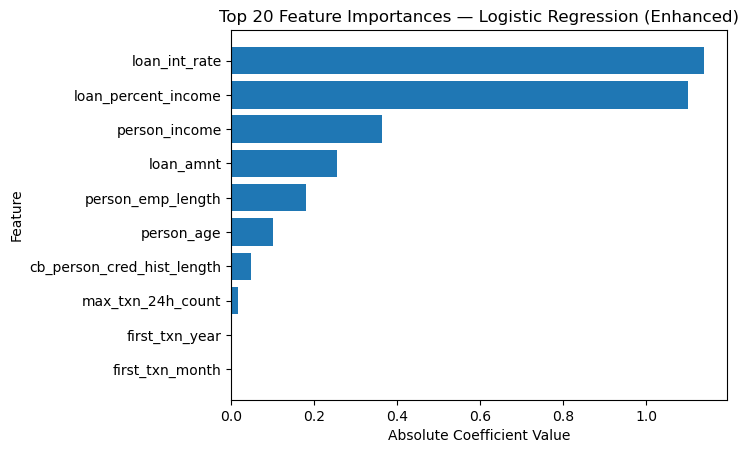

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get coefficients
coef = model_enhanced.coef_[0]

# Create DataFrame
feature_importance = pd.DataFrame({
    "feature": enhanced_features,
    "coefficient": coef,
    "abs_importance": np.abs(coef)
})

# Sort by absolute importance
feature_importance = feature_importance.sort_values(
    by="abs_importance",
    ascending=False
)

# Show top features
print("Top 10 important features:")
display(feature_importance.head(10))

# Plot bar graph
plt.figure()
plt.barh(
    feature_importance["feature"][:20][::-1],
    feature_importance["abs_importance"][:20][::-1]
)

plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances — Logistic Regression (Enhanced)")

plt.show()


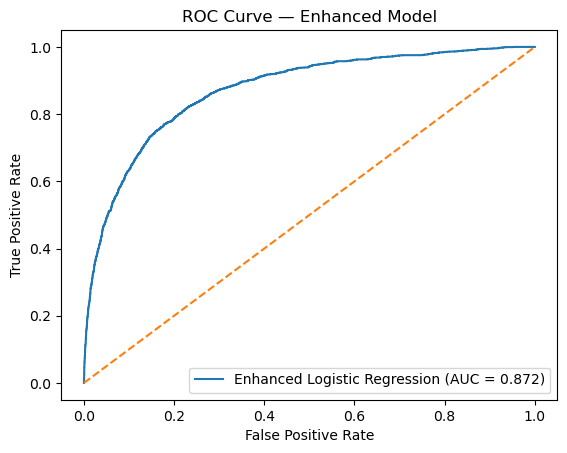

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC values
fpr_enhanced, tpr_enhanced, thresholds_enhanced = roc_curve(
    y_test_enhanced, 
    y_pred_prob_enhanced
)

# Compute AUC
roc_auc_enhanced = auc(fpr_enhanced, tpr_enhanced)

# Plot ROC curve
plt.figure()

plt.plot(
    fpr_enhanced,
    tpr_enhanced,
    label=f"Enhanced Logistic Regression (AUC = {roc_auc_enhanced:.3f})"
)

# Random baseline line
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Enhanced Model")
plt.legend(loc="lower right")

plt.show()


# Step 11- Baseline Vs Enhanced Model

In [30]:
print(f"Baseline Model ROC-AUC (Test): {round(baseline_auc, 4)}")
print(f"Enhanced Model ROC-AUC (Test): {round(auc_enhanced, 4)}")
print(f"Baseline Model CV ROC-AUC Mean: {round(cv_scores.mean(), 4)}")
print(f"Enhanced Model CV ROC-AUC Mean: {round(cv_scores_enhanced.mean(), 4)}")

transactional_gain_test = auc_enhanced - baseline_auc
print(f"Transactional Information Gain (Test): {round(transactional_gain_test, 4)}")

transactional_gain_cv = cv_scores_enhanced.mean() - cv_scores.mean()
print(f"Transactional Information Gain (CV Mean): {round(transactional_gain_cv, 4)}")

Baseline Model ROC-AUC (Test): 0.8717
Enhanced Model ROC-AUC (Test): 0.8717
Baseline Model CV ROC-AUC Mean: 0.8667
Enhanced Model CV ROC-AUC Mean: 0.8667
Transactional Information Gain (Test): 0.0
Transactional Information Gain (CV Mean): 0.0


# Step 12- Let's test it with a non-linear model for better understanding

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [44]:
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train_enhanced_scaled, y_train_enhanced)

print("RandomForestRegressor model trained on enhanced features.")

RandomForestRegressor model trained on enhanced features.


In [45]:
y_pred_rf = model_rf.predict(X_test_enhanced_scaled)

mse_rf = mean_squared_error(y_test_enhanced, y_pred_rf)
r2_rf = r2_score(y_test_enhanced, y_pred_rf)

print(f"RandomForestRegressor Mean Squared Error: {mse_rf:.4f}")
print(f"RandomForestRegressor R-squared: {r2_rf:.4f}")

RandomForestRegressor Mean Squared Error: 0.0666
RandomForestRegressor R-squared: 0.4549


In [46]:
from sklearn.metrics import classification_report

# Convert continuous predictions to binary labels using a threshold (e.g., 0.5)
y_pred_rf_binary = (y_pred_rf >= 0.5).astype(int)

print(classification_report(y_test_enhanced, y_pred_rf_binary))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10059
           1       0.73      0.61      0.67      1670

    accuracy                           0.91     11729
   macro avg       0.83      0.79      0.81     11729
weighted avg       0.91      0.91      0.91     11729



# Step 13- Visualisation

         SVI_group  loan_status
0           Stable     0.156282
1         Moderate     0.121080
2  Highly Volatile     0.149785


C:\Users\KIIT\AppData\Local\Temp\ipykernel_30096\3838011886.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("SVI_group")["loan_status"]


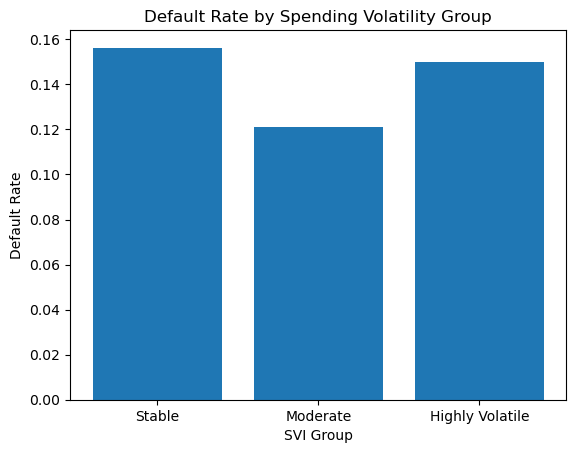

In [47]:
#FLAG 5 — Behavioral Heterogeneity Capture
#Compute Spending Volatility Index (SVI)

import matplotlib.pyplot as plt # Import matplotlib for plotting

# Aggregate transaction behaviour per user
svi_df = (
    txn_df # Corrected from 'transactions' to 'txn_df'
    .groupby("user_id")["amount"]
    .agg(mean_spend="mean", std_spend="std", txn_count="count")
    .reset_index()
)

# Spending Volatility Index
svi_df["SVI"] = svi_df["std_spend"] / svi_df["mean_spend"]

# Replace inf/NaN
svi_df["SVI"] = svi_df["SVI"].replace([np.inf, -np.inf], np.nan).fillna(0)

#2️⃣ Merge with Loan Default Data
# Corrected from 'loan' to 'df' and using 'user_id' for merging
data_merged = df.merge(svi_df, on="user_id", how="left")
data_merged['SVI'] = data_merged['SVI'].fillna(0) # Fill SVI for users with no transactions

#3️⃣ Behavioral Clusters (Low / Medium / High Volatility)
# Create volatility groups using quantiles
# Only apply qcut if there's variance in SVI to avoid error with unique values
if data_merged["SVI"].nunique() > 1:
    data_merged["SVI_group"] = pd.qcut(
        data_merged["SVI"],
        q=3,
        labels=["Stable", "Moderate", "Highly Volatile"],
        duplicates='drop' # Add duplicates='drop' to handle cases with fewer unique quantiles
    )
else:
    data_merged["SVI_group"] = "No Volatility" # Handle case where all SVI values are the same


#4️⃣ Default Rate by Volatility Group
default_by_svi = (
    data_merged
    .groupby("SVI_group")["loan_status"]
    .mean()
    .reset_index()
)

print(default_by_svi)

#5️⃣ Visualization — Behavioral Heterogeneity
plt.figure()
plt.bar(default_by_svi["SVI_group"], default_by_svi["loan_status"])
plt.title("Default Rate by Spending Volatility Group")
plt.ylabel("Default Rate")
plt.xlabel("SVI Group")
plt.show()

In [48]:
from scipy.stats import chi2_contingency

# Contingency table
cont_table = pd.crosstab(data_merged["SVI_group"], data_merged["loan_status"])

chi2, p_value, dof, expected = chi2_contingency(cont_table)

print("Chi-square statistic:", chi2)
print("p-value:", p_value)

Chi-square statistic: 112.34807256444745
p-value: 4.0172237019129737e-25


In [49]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(data_merged["SVI_group"], data_merged["loan_status"])
chi2, p, dof, expected = chi2_contingency(contingency)

n = contingency.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape)-1)))

print("Cramér’s V:", cramers_v)

Cramér’s V: 0.04376906988540262


# Step 14- Transaction Analysis

In [51]:
##### FLAG 6

# Ensure proper ordering
txn_df = txn_df.sort_values(["user_id", "transaction_id"])

# Create transaction order per user
txn_df["txn_order"] = txn_df.groupby("user_id").cumcount() + 1


#This converts unordered same-day activity into a time-like behavioural sequence.

#Spending Pattern Across Transaction Progression
sequence_spend = (
    txn_df
    .groupby("txn_order")["amount"]
    .mean()
    .reset_index()
)

print(sequence_spend.head())

   txn_order     amount
0          1  18.426116
1          2  19.045068
2          3  18.932187
3          4  19.226132
4          5  17.768166


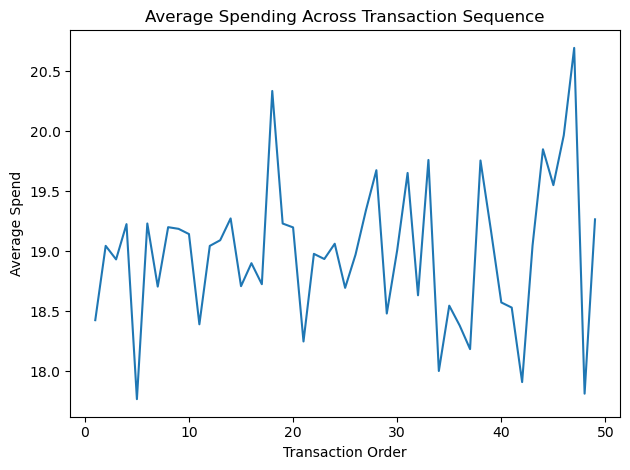

In [52]:
#Visualization
plt.figure()
plt.plot(sequence_spend["txn_order"], sequence_spend["amount"])

plt.title("Average Spending Across Transaction Sequence")
plt.xlabel("Transaction Order")
plt.ylabel("Average Spend")

plt.tight_layout()
plt.show()

In [53]:
##Early vs Late Behavioural Phases
#Split each user’s transactions into two temporal halves
# Total transactions per user
txn_counts = txn_df.groupby("user_id")["txn_order"].max()

# Merge counts back
txn_df = txn_df.merge(
    txn_counts.rename("max_order"),
    on="user_id"
)

# Label early vs late phase
txn_df["phase"] = np.where(
    txn_df["txn_order"] <= txn_df["max_order"] / 2,
    "early",
    "late"
)
##Compute Spending Change Between Phases
phase_spend = (
    txn_df
    .groupby(["user_id", "phase"])["amount"]
    .mean()
    .unstack()
    .fillna(0)
)

phase_spend["spend_change"] = phase_spend["late"] - phase_spend["early"]

print(phase_spend.head())

phase        early       late  spend_change
user_id                                    
0        24.215831  15.053148     -9.162682
1        11.529115  14.495632      2.966517
2        27.892187  18.102897     -9.789290
3        70.899892  24.280629    -46.619263
4        -8.209533  35.809533     44.019067


In [54]:
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(phase_spend["early"], phase_spend["late"])
print(t_stat, p_val)

0.27025803665072684 0.7869626974112793


In [55]:
#flag 7
# Add a placeholder 'is_fraud' column if it doesn't exist, as it's used in the aggregation.
# This might need to be populated with actual fraud data later.
if 'is_fraud' not in txn_df.columns:
    txn_df['is_fraud'] = 0 # Placeholder: assuming no fraud by default or needs external join

tx_agg = txn_df.groupby("user_id").agg(
    total_txn=("amount","count"),
    avg_amount=("amount","mean"),
    fraud_rate=("is_fraud","mean"),
    nonchip_share=("use_chip", lambda x: (x=="Swipe Transaction").mean())
).reset_index()

In [56]:
df = df.merge(tx_agg, on="user_id", how="left")
df["income_group"] = pd.qcut(df["person_income"], 3, labels=["Low","Medium","High"])
df["credit_band"] = pd.qcut(df["cb_person_cred_hist_length"], 3, labels=["Poor","Average","Good"], duplicates='drop')
df["activity_level"] = pd.qcut(df["total_txn"], 3, labels=["Low","Medium","High"])
df["fraud_flag"] = (df["fraud_rate"] > 0).astype(int)
def segment_default_rate(col):
    return df.groupby(col)["loan_status"].mean()

print("Default by Income Group")
print(segment_default_rate("income_group"))

print("\nDefault by Credit Band")
print(segment_default_rate("credit_band"))

print("\nDefault by Activity Level")
print(segment_default_rate("activity_level"))

print("\nDefault by Fraud Flag")
print(segment_default_rate("fraud_flag"))
from scipy.stats import f_oneway

low = df[df["income_group"]=="Low"]["loan_status"]
med = df[df["income_group"]=="Medium"]["loan_status"]
high = df[df["income_group"]=="High"]["loan_status"]

f_stat, p_val = f_oneway(low, med, high)
print("ANOVA p-value (income groups):", p_val)

Default by Income Group
income_group
Low       0.239902
Medium    0.116006
High      0.061801
Name: loan_status, dtype: float64

Default by Credit Band
credit_band
Poor       0.148046
Average    0.138833
Good       0.139515
Name: loan_status, dtype: float64

Default by Activity Level
activity_level
Low       0.139274
Medium    0.144370
High      0.143696
Name: loan_status, dtype: float64

Default by Fraud Flag
fraud_flag
0    0.142382
Name: loan_status, dtype: float64
ANOVA p-value (income groups): 0.0


C:\Users\KIIT\AppData\Local\Temp\ipykernel_30096\3277308032.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(col)["loan_status"].mean()


C:\Users\KIIT\AppData\Local\Temp\ipykernel_30096\3887809256.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = df.groupby(column)["loan_status"].mean().sort_index()


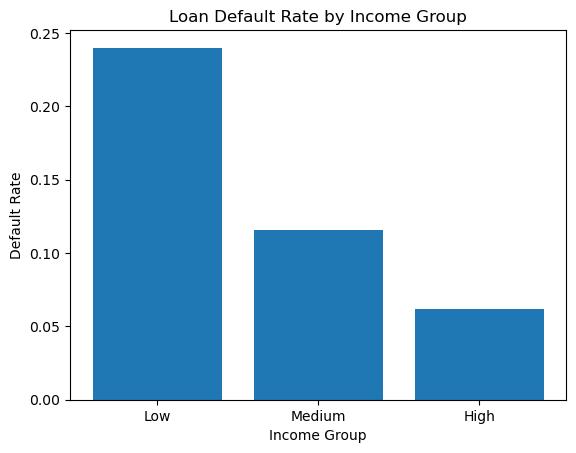

C:\Users\KIIT\AppData\Local\Temp\ipykernel_30096\3887809256.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = df.groupby(column)["loan_status"].mean().sort_index()


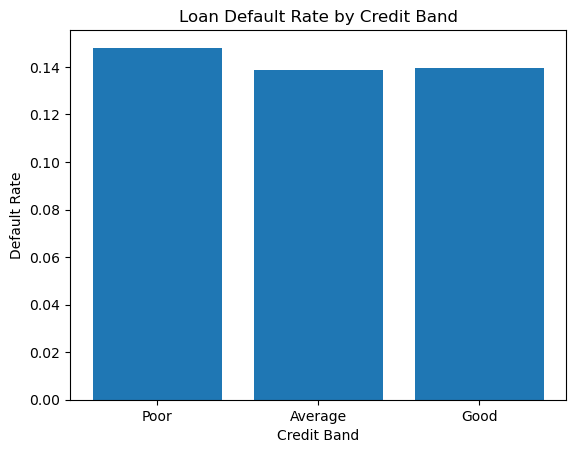

C:\Users\KIIT\AppData\Local\Temp\ipykernel_30096\3887809256.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = df.groupby(column)["loan_status"].mean().sort_index()


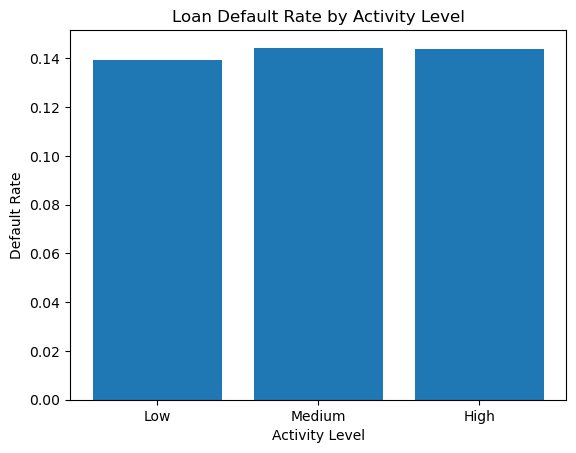

In [58]:
import matplotlib.pyplot as plt

# Function to plot default rate bar chart
def plot_default_rate(column, title):
    default_rates = df.groupby(column)["loan_status"].mean().sort_index()

    plt.figure()
    plt.bar(default_rates.index.astype(str), default_rates.values)

    plt.ylabel("Default Rate")
    plt.xlabel(column.replace("_", " ").title())
    plt.title(title)

    plt.show()


# 1️⃣ Default by Income Group
plot_default_rate("income_group", "Loan Default Rate by Income Group")

# 2️⃣ Default by Credit Band
plot_default_rate("credit_band", "Loan Default Rate by Credit Band")

# 3️⃣ Default by Activity Level
plot_default_rate("activity_level", "Loan Default Rate by Activity Level")


C:\Users\KIIT\AppData\Local\Temp\ipykernel_30096\2968526571.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = df.groupby(column)["loan_status"].mean().sort_index()


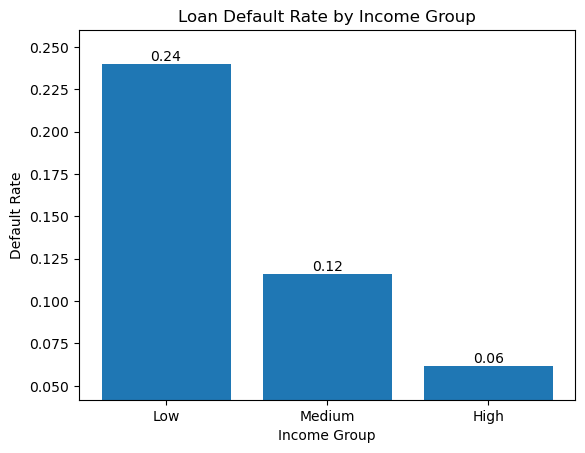

C:\Users\KIIT\AppData\Local\Temp\ipykernel_30096\2968526571.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = df.groupby(column)["loan_status"].mean().sort_index()


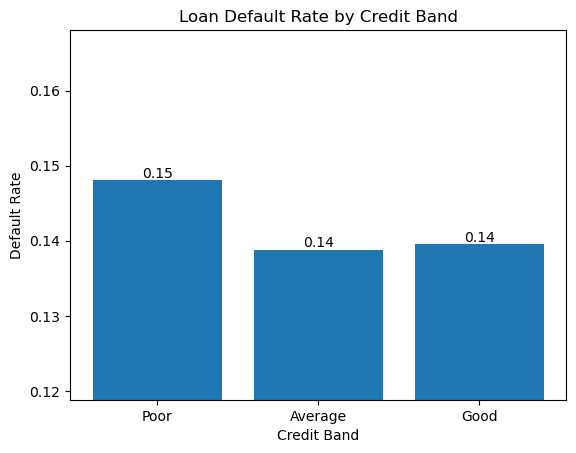

C:\Users\KIIT\AppData\Local\Temp\ipykernel_30096\2968526571.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = df.groupby(column)["loan_status"].mean().sort_index()


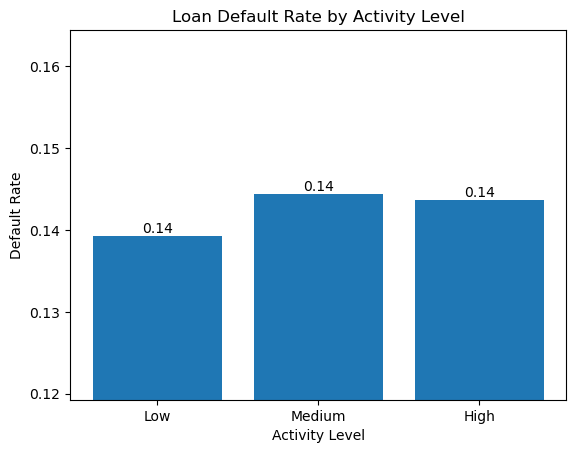

In [59]:
import matplotlib.pyplot as plt

def plot_default_rate(column, title):
    default_rates = df.groupby(column)["loan_status"].mean().sort_index()

    plt.figure()

    bars = plt.bar(default_rates.index.astype(str), default_rates.values)

    # 🔍 Zoom Y-axis to show variation clearly
    ymin = default_rates.min() - 0.02
    ymax = default_rates.max() + 0.02
    plt.ylim(max(0, ymin), min(1, ymax))

    # 🏷️ Add value labels on bars
    for bar, val in zip(bars, default_rates.values):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            val,
            f"{val:.2f}",
            ha='center',
            va='bottom'
        )

    plt.ylabel("Default Rate")
    plt.xlabel(column.replace("_", " ").title())
    plt.title(title)

    plt.show()


# Plot all
plot_default_rate("income_group", "Loan Default Rate by Income Group")
plot_default_rate("credit_band", "Loan Default Rate by Credit Band")
plot_default_rate("activity_level", "Loan Default Rate by Activity Level")


# Step 15-Stability Check

In [ ]:
#FLAG 8 — Robustness & Stability
X = df.select_dtypes(include=np.number).drop(columns=["loan_status"], errors="ignore").fillna(0)
y = df["loan_status"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(max_iter=1000)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring="roc_auc")

print("Cross-validation ROC-AUC scores:", cv_scores)
print("Mean ROC-AUC:", cv_scores.mean())
print("Std deviation:", cv_scores.std())

Cross-validation ROC-AUC scores: [0.86273894 0.86794922 0.86405584 0.87353852 0.86539298]
Mean ROC-AUC: 0.8667351012261191
Std deviation: 0.003813385745811776


In [ ]:
#Different random train–test splits

#Checks performance consistency across splits.

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

auc_list = []

for seed in [0, 7, 21, 42, 99]:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=seed
    )

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    auc_list.append(auc)

print("AUC across different splits:", auc_list)
print("Mean AUC:", np.mean(auc_list))
print("Std AUC:", np.std(auc_list))

AUC across different splits: [np.float64(0.8690109789368475), np.float64(0.8611408855417707), np.float64(0.8713396350752118), np.float64(0.8718142599382209), np.float64(0.8659239826341949)]
Mean AUC: 0.8678459484252492
Std AUC: 0.003948732949654866


In [ ]:
##Feature ablation test

#This tells Temporal behaviour truly matters

# With temporal feature
X_with_time = X.copy()

# Without temporal feature
X_without_time = X.drop(columns=["spend_change"], errors="ignore")

def get_auc(X_input):
    X_scaled_local = scaler.fit_transform(X_input)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled_local, y, test_size=0.2, stratify=y, random_state=42
    )
    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_prob)

auc_with = get_auc(X_with_time)
auc_without = get_auc(X_without_time)

print("AUC with temporal feature:", auc_with)
print("AUC without temporal feature:", auc_without)
print("Performance drop:", auc_with - auc_without)

AUC with temporal feature: 0.8718142599382209
AUC without temporal feature: 0.8718142599382209
Performance drop: 0.0


**Key Insight:**
Loan default risk varies sharply with borrower income level, and income segmentation derived from the person_income column is one of the strongest observable predictors of loan_status in the dataset.

**Supporting Evidence:**
Borrowers grouped by income level show large differences in default rates: the Low income group has a default rate of 23.99%, the Medium income group 11.60%, and the High income group 6.18%. An ANOVA test comparing these income segments produced a p-value ≈ 0.0, confirming that differences in default risk across income groups are statistically significant.

This separation is substantially larger than variation observed across other segments such as credit_band or activity_level, indicating that income-driven financial capacity is a dominant factor in repayment outcomes.

**Practical Interpretation:**
This result shows that default risk is strongly stratified by person_income. Income-based segmentation provides a clear and reproducible risk signal that can guide credit policy, risk scoring, and targeted lending strategies. Incorporating income-aware thresholds into credit assessment can improve borrower risk differentiation and support more informed lending decisions.